# Node matching
Here we briefly explain the idea of using network (or graph) matching to uncover an
alignment between the nodes of two networks.

## Preliminaries

In [1]:
from networkx.classes.graph import Graph
from pkg.utils import set_warnings

import datetime
import pprint
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from giskard.utils import get_paired_inds
from graspologic.align import OrthogonalProcrustes, SeedlessProcrustes
from graspologic.embed import AdjacencySpectralEmbed, select_dimension
from graspologic.utils import augment_diagonal, binarize, pass_to_ranks
from hyppo.ksample import KSample
from pkg.data import (
    load_maggot_graph,
    load_navis_neurons,
    load_network_palette,
    load_node_palette,
)
from pkg.io import savefig
from pkg.plot import set_theme
from sklearn.metrics.pairwise import cosine_similarity
from src.pymaid import start_instance
from src.visualization import simple_plot_neurons
from pkg.plot import set_theme
from graspologic.simulations import er_corr
import networkx as nx
from giskard.plot import merge_axes, soft_axis_off
from matplotlib.colors import ListedColormap
from graspologic.match import GraphMatch
from graspologic.plot import heatmap


def stashfig(name, **kwargs):
    foldername = "introduce_node_matching"
    savefig(name, foldername=foldername, **kwargs)


network_palette, NETWORK_KEY = load_network_palette()
t0 = time.time()
set_theme()

## Illustrate graph matching on a simulated dataset

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


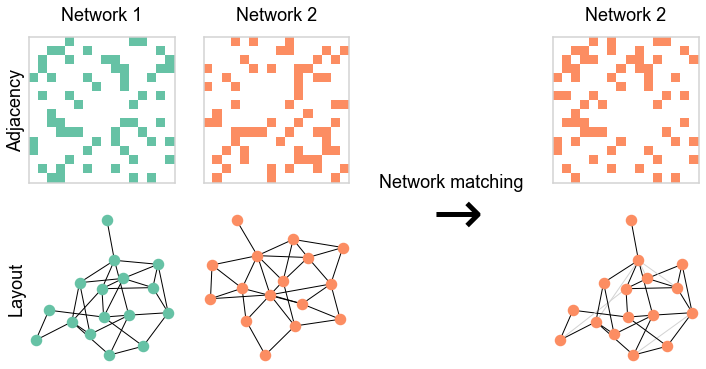

In [2]:


def set_light_border(ax):
    for side in ["left", "right", "top", "bottom"]:
        ax.spines[side].set_visible(True)
        ax.spines[side].set_linewidth(1.5)
        ax.spines[side].set_color("lightgrey")


# sample two networks
np.random.seed(88888)
A1, A2 = er_corr(16, 0.3, 0.9)

# set up the plot
heatmap_kws = dict(cbar=False, center=None)
fig, axs = plt.subplots(2, 4, figsize=(12, 6))

# plot graph 1 adjacency
ax = axs[0, 0]
colors = ["white", network_palette["Left"]]
cmap = ListedColormap(colors)
heatmap(A1, ax=ax, title="Network 1", cmap=cmap, **heatmap_kws)
set_light_border(ax)
ax.set_ylabel("Adjacency")

# plot graph 2 adjacency, with a random shuffling of the nodes
ax = axs[0, 1]
shuffle_inds = np.random.permutation(len(A2))
colors = ["white", network_palette["Right"]]
cmap = ListedColormap(colors)
heatmap(
    A2[shuffle_inds][:, shuffle_inds],
    ax=ax,
    title="Network 2",
    cmap=cmap,
    **heatmap_kws,
)
set_light_border(ax)

# create networkx graphs from the adjacencies
g1 = nx.from_numpy_array(A1)
g2 = nx.from_numpy_array(A2)

# plot the first graph as a ball-and-stick
ax = axs[1, 0]
pos = nx.kamada_kawai_layout(g1)
nx.draw_networkx(
    g1,
    with_labels=False,
    pos=pos,
    ax=ax,
    node_color=network_palette["Left"],
    node_size=100,
)
ax.axis("on")
soft_axis_off(ax)
ax.set_ylabel("Layout")

# plot the second graph as a ball-and-stick, with it's own predicted layout
ax = axs[1, 1]
nx.draw_kamada_kawai(g2, ax=ax, node_color=network_palette["Right"], node_size=100)

# draw an arrow in the middle of the plot
ax = merge_axes(fig, axs, rows=None, cols=2)
ax.axis("off")
text = "Network matching"
ax.text(
    0.5,
    0.55,
    text,
    ha="center",
    va="center",
)
text = r"$\rightarrow$"
ax.text(
    0.5,
    0.45,
    text,
    ha="center",
    va="center",
    fontsize=60,
)

# graph match to recover the pairing
gm = GraphMatch(n_init=30)
perm_inds = gm.fit_predict(A1, A2)
ax = axs[0, 3]
heatmap(A2[perm_inds][:, perm_inds], ax=ax, title="Network 2", cmap=cmap, **heatmap_kws)
set_light_border(ax)

# plot the second network after alignment, color edges based on matchedness
edge_colors = []
edgelist = []
for edge in g2.edges:
    edgelist.append(edge)
    if g1.has_edge(*edge):
        edge_colors.append("black")
    else:
        edge_colors.append("lightgrey")
ax = axs[1, 3]
nx.draw_networkx(
    g2,
    with_labels=False,
    pos=pos,
    ax=ax,
    node_color=network_palette["Right"],
    node_size=100,
    edgelist=edgelist,
    edge_color=edge_colors,
)

soft_axis_off(ax)
stashfig("network-matching-explanation")

In [3]:
elapsed = time.time() - t0
delta = datetime.timedelta(seconds=elapsed)
print("----")
print(f"Script took {delta}")
print(f"Completed at {datetime.datetime.now()}")
print("----")

----
Script took 0:00:01.799971
Completed at 2021-05-12 14:46:36.165143
----
